## DNN with He/Xavier initialization and Adam optimizer

## Imports

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(1)

## Dataset

In [2]:
DATADIR = "C:/Users/Omkar/ML and DS/Dog/dataset"

In [3]:
CATEGORIES = ["Golden1", "German1"]
img_size = 64

### Creating training data

In [4]:
training_data=[]

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array,(img_size,img_size))
            training_data.append([new_array, class_num])

In [5]:
create_training_data()
print(len(training_data))

604


In [6]:
random.shuffle(training_data)

### Seperation of X,y

In [7]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
print("Shape of X = "+ str(X.shape))
print("Shape of y = " + str(y.shape))

Shape of X = (604, 64, 64, 3)
Shape of y = (604,)


In [10]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

**Reshaping y**

In [11]:
y_train = y_train.reshape((1, y_train.shape[0]))
y_test = y_test.reshape((1, y_test.shape[0]))

Example of picture

y= [0]


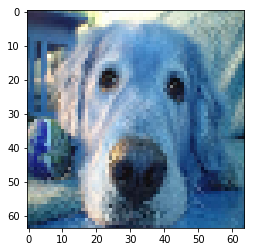

In [12]:
index = 99
plt.imshow(x_train[index])
print("y= "+ str(y_train[:,index]))

Explore Dataset

In [13]:
m_train = x_train.shape[0]
m_test = x_test.shape[0]
num_px = x_train.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(x_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x shape: " + str(x_test.shape))
print ("test_set_y shape: " + str(y_test.shape))

Number of training examples: m_train = 422
Number of testing examples: m_test = 182
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (422, 64, 64, 3)
train_set_y shape: (1, 422)
test_set_x shape: (182, 64, 64, 3)
test_set_y shape: (1, 182)


Reshaping Training and Test examples

In [14]:
train_set_x_flatten = x_train.reshape(x_train.shape[0], -1).T
test_set_x_flatten = x_test.reshape(x_test.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(y_test.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 422)
train_set_y shape: (1, 422)
test_set_x_flatten shape: (12288, 182)
test_set_y shape: (1, 182)
sanity check after reshaping: [ 81  92 121  72 107]


Standardizing Dataset

In [15]:
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.

### Helper Functions

In [16]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A,cache

In [17]:
def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    cache = Z
    return A,cache

In [18]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert(dZ.shape == Z.shape)
    return dZ

In [19]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    assert(dZ.shape == Z.shape)
    return dZ

### Initialization

In [20]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],
                                                   layer_dims[l-1])*(np.sqrt(2. / layer_dims[l-1]))
        
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l],
                                                  layer_dims[l-1]))
        
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

In [22]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W" + str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b" + str(l+1)])
    
    return v, s

### Forward Prop

In [23]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [24]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache"
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache"
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [25]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2    # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W'+ str(l)],
                                             parameters['b'+ str(l)],
                                             activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)],
                                          parameters['b' + str(L)],
                                          activation= "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

### Cost Function

$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [42]:
def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters) // 2
    W_r = np.zeros((1,1))
    
    for l in range(L):
        
        W = parameters["W"+str(l+1)]
        W = np.sum(np.square(W))
        W_r += W
        
        
    cost = (-(1/m) * np.sum(np.multiply(np.log(AL),Y) + np.multiply(np.log(1-AL),1-Y))) + (lambd/(2*m))*W_r
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

### Backward Prop

#### Linear back prop

In [43]:
def linear_backward(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ,A_prev.T)+ (lambd/m)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [44]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache,lambd= 0.7)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache, lambd = 0.7)
    
    return dA_prev, dW, db

### Update Parameters

In [60]:
def update_parameters(parameters, grads, v, s, t, learning_rate, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2 # number of layers in the neural network
    
    v_corrected = {}    # Initializing first moment estimate
    s_corrected = {}

    for l in range(L):
        
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1-beta1)*grads['db' + str(l+1)]
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-np.power(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-np.power(beta1,t))
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*np.square(grads['db' + str(l+1)])
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-np.power(beta2,t))
        
        parameters["W" + str(l+1)] = parameters["W"+ str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/np.sqrt(s_corrected["dW" + str(l+1)] +epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/np.sqrt(s_corrected["db" + str(l+1)]+epsilon)
    
    return parameters, v, s

### Predict

In [61]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

## Deep NN

### L-Model Backward

In [62]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    # Lth layer (SIGMOID -> LINEAR) gradients.
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)],
                                   current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp 
        grads["db" + str(l + 1)] = db_temp

    return grads

### L-Layer NN

In [71]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.000002,num_iterations=5000, 
                  beta = 0.8, beta1 = 0.8, beta2 = 0.899,  epsilon = 1e-8, print_cost = True):#lr was 0.009
    
    costs = []   # keep track of cost
    t = 0
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost
        cost = compute_cost(AL, Y, parameters, lambd = 0.7)
    
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters
        t = t + 1
        parameters, v, s = update_parameters(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
                
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.764635
Cost after iteration 1000: 0.473535
Cost after iteration 2000: 0.348153
Cost after iteration 3000: 0.269270
Cost after iteration 4000: 0.215707
Cost after iteration 5000: 0.180278
Cost after iteration 6000: 0.152495
Cost after iteration 7000: 0.130945
Cost after iteration 8000: 0.114728
Cost after iteration 9000: 0.101975
Cost after iteration 10000: 0.091941
Cost after iteration 11000: 0.084453
Cost after iteration 12000: 0.088775
Cost after iteration 13000: 0.084777
Cost after iteration 14000: 0.081010


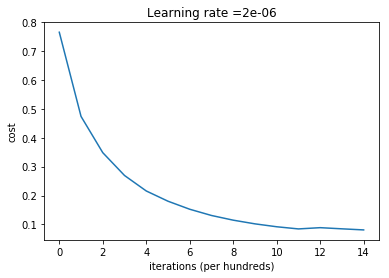

In [72]:
layer_dims = [12288,4,1] # 4-layer
parameters = L_layer_model(train_x,y_train,layer_dims,num_iterations=15000,print_cost=True)

In [73]:
pred_train = predict(train_x, y_train, parameters)

Accuracy: 0.9905213270142181


In [76]:
pred_test = predict(test_x, y_test, parameters)

Accuracy: 0.7912087912087913


$$\begin{cases}
v_{W^{[l]}} = \beta_1 v_{W^{[l]}} + (1 - \beta_1) \frac{\partial J }{ \partial W^{[l]} } \\
v^{corrected}_{W^{[l]}} = \frac{v_{W^{[l]}}}{1 - (\beta_1)^t} \\
s_{W^{[l]}} = \beta_2 s_{W^{[l]}} + (1 - \beta_2) (\frac{\partial J }{\partial W^{[l]} })^2 \\
s^{corrected}_{W^{[l]}} = \frac{s_{W^{[l]}}}{1 - (\beta_2)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{W^{[l]}}}{\sqrt{s^{corrected}_{W^{[l]}}}+\varepsilon}
\end{cases}$$